In [2]:
import os
import requests
import torch
import torchaudio
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#housekeeping
csv_file = "all_tracks-1.csv"
all_tracks = pd.read_csv(csv_file)
#data_path = 'C://users/khala/all_tracks_sg' 
data_path = '/content/drive/MyDrive/all_tracks_sg' 
files = os.listdir(data_path)

In [6]:
#image i/o setup
from pathlib import Path
import torchvision.transforms as T
from torchvision.io import read_image


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
#normalize images
import torchvision.transforms as transforms
transform = transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))

In [8]:
#setup train and test set: sizes 609 and 100
labels_train = torch.zeros(len(files)-100)
images_train = []

for i in range(len(files)-100):
  labels_train[i] = all_tracks[all_tracks['track_id'] == files[i][0:len(files[1])-4]].danceability.item() #labels: danceability value from csv file
  images_train.append(transform(read_image(data_path + '/' + files[i])/255))

image_tens_train = torch.zeros(len(files)-100, 4, 32, 32) #the tensor containing all train image
for i in range(len(files)-100):
  image_tens_train[i,:,:,:] = torchvision.transforms.functional.resize(images_train[i], (32, 32))

labels_test = torch.zeros(100)
images_test = []

for i in range(100):
  labels_test[i] = all_tracks[all_tracks['track_id'] == files[i+len(files)-100][0:len(files[1])-4]].danceability.item()
  images_test.append(transform(read_image(data_path + '/' + files[i+len(files)-100])/255))

image_tens_test = torch.zeros(100, 4, 32, 32) #tensor containing all test image
for i in range(100):
  image_tens_test[i,:,:,:] = torchvision.transforms.functional.resize(images_test[i], (32, 32))

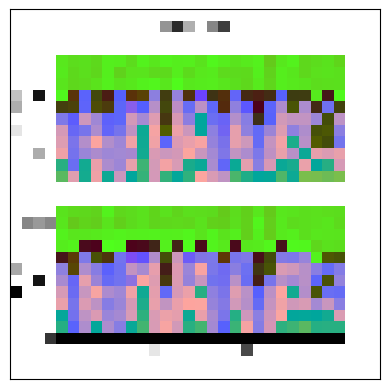

In [9]:
show([image_tens_train[1,:,:,:]])

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 32)
        self.fc3 = nn.Linear(32, 1)       
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)   # flatten features

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

net = Net()

In [11]:
import torch.optim as optim

criterion = nn.MSELoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(100):  # loop over the dataset multiple times (here we are not using minibatches)
  optimizer.zero_grad()
  output = net(image_tens_train).squeeze()
  loss = criterion(output, labels_train.logit())
  loss.backward()
  optimizer.step()
  loss_running = loss.item()
  print(loss_running)


1.8600120544433594
1.8507400751113892
1.833173394203186
1.8083686828613281
1.7775263786315918
1.7418789863586426
1.702674388885498
1.661122441291809
1.617910385131836
1.5733473300933838
1.5277807712554932
1.4815857410430908
1.4352753162384033
1.3895542621612549
1.346811294555664
1.3057996034622192
1.265262246131897
1.2252100706100464
1.1857727766036987
1.1471015214920044
1.1092609167099
1.0721540451049805
1.035779595375061
1.0002923011779785
0.9660249948501587
0.9326919317245483
0.9001033902168274
0.8682620525360107
0.8371917605400085
0.8070309162139893
0.7778558135032654
0.7496076226234436
0.7223302125930786
0.6961422562599182
0.6711813807487488
0.6475997567176819
0.6255837678909302
0.6053553223609924
0.5871379375457764
0.5711408257484436
0.5575782656669617
0.5466368794441223
0.5384488105773926
0.5330469608306885
0.5303230881690979
0.5300055146217346
0.5316569209098816
0.5346928834915161
0.5384336709976196
0.5422008633613586
0.5453987121582031
0.5475949048995972
0.5485687255859375
0.5

In [14]:
acc = 0
for i in range(100):
  output = torch.sigmoid(net(image_tens_test[i,:,:,:])) > 0.6
  label_temp = labels_test[i] > 0.6
  if (output == label_temp):
    acc += 1
  
acc = acc/100
acc

0.83